In [1]:
import os
import cooler
import cooltools.snipping
import bioframe
import pandas as pd
from NGS import HiCTools as HT
from collections import defaultdict
import re
import numpy as np
from typing import Callable
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.stats import ttest_ind, mannwhitneyu
import matplotlib.colors as cl
import matplotlib
import warnings
from typing import Tuple

In [2]:
# ignore warnings (log10(0))
warnings.simplefilter("ignore", RuntimeWarning)

# Define plotting parameters

In [3]:
matplotlib.rcParams.update({"font.size": 12})
matplotlib.rcParams.update({"pdf.fonttype": 42})

# Define functions

In [4]:
def recDict():
    return defaultdict(recDict)

def getPileFrame(clr: cooler.Cooler, expected: pd.DataFrame ,windowsize: int = 4 * 10**4,
                    func: Callable = np.nanmean, regions: pd.DataFrame = pd.DataFrame(),
                    norm: bool = True) -> pd.DataFrame:
    """Takes a cooler file (clr),
    a windowsize (windowsize), a summary
    function (func) and a set of genomic
    regions to calculate the pairing score
    as follows: A square with side-length windowsize
    is created for each of the entries in the supplied genomics
    regions and the summary function applied to the Hi-C pixels
    at the location in the supplied cooler file. The results are
    returned as a dataframe. If no regions are supplied, regions
    are constructed for each bin in the cooler file to
    construct a genome-wide pairing score."""
    # Check whether genomic regions were supplied
    if len(regions) == 0:
        # If no regions are supplied, pregenerate all bins; drop bins with nan weights
        regions = clr.bins()[:].dropna()
        # find midpoint of each bin to assign windows to each midpoint
        regions.loc[:, "mid"] = (regions["start"] + regions["end"])//2
    # drop nan rows from regions
    regions = regions.dropna()
    # fix indices
    regions.index = range(len(regions))
    regions.loc[:, "binID"] = range(len(regions))
    # Chromosomal arms are needed so each process only extracts a subset from the file
    arms = HT.getArmsHg19()
    # extract all windows
    windows = HT.assignRegions(windowsize, clr.binsize, regions["chrom"],
                            regions["mid"], arms)
    # add binID to later merge piles
    windows.loc[:, "binID"] = regions["binID"]
    windows = windows.dropna()
    # generate pileup
    pile = HT.doPileupObsExp(clr, expected, windows, collapse=False)
    # convert to dataframe
    pileFrame = HT.pileToFrame(pile)
    # replace inf with nan
    pileFrame = pileFrame.replace([np.inf, -np.inf], np.nan)
    # apply function to each row (row = individual window)
    summarized = pileFrame.apply(func, axis=1)
    # subset regions with regions that were assigned windows
    output = pd.merge(regions, windows, on="binID", suffixes=("", "_w")).dropna()
    return output, summarized

def getPairingScoreObsExp(clr: cooler.Cooler, expected: pd.DataFrame ,windowsize: int = 4 * 10**4,
                    func: Callable = np.nanmean, regions: pd.DataFrame = pd.DataFrame(),
                    norm: bool = True) -> pd.DataFrame:
    """Takes a cooler file (clr),
    a windowsize (windowsize), a summary
    function (func) and a set of genomic
    regions to calculate the pairing score
    as follows: A square with side-length windowsize
    is created for each of the entries in the supplied genomics
    regions and the summary function applied to the Hi-C pixels
    at the location in the supplied cooler file. The results are
    returned as a dataframe. If no regions are supplied, regions
    are constructed for each bin in the cooler file to
    construct a genome-wide pairing score."""
    # Check whether genomic regions were supplied
    if len(regions) == 0:
        # If no regions are supplied, pregenerate all bins; drop bins with nan weights
        regions = clr.bins()[:].dropna()
        # find midpoint of each bin to assign windows to each midpoint
        regions.loc[:, "mid"] = (regions["start"] + regions["end"])//2
    # drop nan rows from regions
    regions = regions.dropna()
    # fix indices
    regions.index = range(len(regions))
    regions.loc[:, "binID"] = range(len(regions))
    # Chromosomal arms are needed so each process only extracts a subset from the file
    arms = HT.getArmsHg19()
    # extract all windows
    windows = HT.assignRegions(windowsize, clr.binsize, regions["chrom"],
                            regions["mid"], arms)
    # add binID to later merge piles
    windows.loc[:, "binID"] = regions["binID"]
    windows = windows.dropna()
    # generate pileup
    pile = HT.doPileupObsExp(clr, expected, windows, collapse=False)
    # convert to dataframe
    pileFrame = HT.pileToFrame(pile)
    # replace inf with nan
    pileFrame = pileFrame.replace([np.inf, -np.inf], np.nan)
    # apply function to each row (row = individual window)
    summarized = pileFrame.apply(func, axis=1)
    # subset regions with regions that were assigned windows
    output = pd.merge(regions, windows, on="binID", suffixes=("", "_w")).dropna()
    # add results
    output.loc[:, "PairingScore"] = summarized
    # normalize by median
    if norm:
        output.loc[:, "PairingScore"] = output["PairingScore"] - np.median(output.dropna()["PairingScore"])
    return output[["chrom", "start", "end", "PairingScore"]]

def getDiagIndices(arr):
    assert arr.shape[0] == arr.shape[1], "Please supply a square array!"
    shape = arr.shape[0]
    return [i + index for index, i in enumerate(range(0, shape**2 - shape + 1, shape))]

def getPairingScore(clr: cooler.Cooler, windowsize: int = 4 * 10**4,
                    func: Callable = np.mean, regions: pd.DataFrame = pd.DataFrame(),
                    norm: bool = True, blankDiag: bool = False) -> pd.DataFrame:
    """Takes a cooler file (clr),
    a windowsize (windowsize), a summary
    function (func) and a set of genomic
    regions to calculate the pairing score
    as follows: A square with side-length windowsize
    is created for each of the entries in the supplied genomics
    regions and the summary function applied to the Hi-C pixels
    at the location in the supplied cooler file. The results are
    returned as a dataframe. If no regions are supplied, regions
    are constructed for each bin in the cooler file to
    construct a genome-wide pairing score."""
    # Check whether genomic regions were supplied
    if len(regions) == 0:
        # If no regions are supplied, pregenerate all bins; drop bins with nan weights
        regions = clr.bins()[:].dropna()
        # find midpoint of each bin to assign windows to each midpoint
        regions.loc[:, "mid"] = (regions["start"] + regions["end"])//2
    # drop nan rows from regions
    regions = regions.dropna()
    # fix indices
    regions.index = range(len(regions))
    regions.loc[:, "binID"] = range(len(regions))
    # Chromosomal arms are needed so each process only extracts a subset from the file
    arms = HT.getArmsHg19()
    # extract all windows
    windows = HT.assignRegions(windowsize, clr.binsize, regions["chrom"],
                            regions["mid"], arms)
    # add binID to later merge piles
    windows.loc[:, "binID"] = regions["binID"]
    windows = windows.dropna()
    # generate pileup
    pile = HT.doPileupICCF(clr, windows, collapse=False)
    # convert to dataframe
    pileFrame = HT.pileToFrame(pile)
    if blankDiag:
        dummyarray = np.arange(pile[:, :, 0].shape[0]**2).reshape(pile[:, :, 0].shape[0], pile[:, :, 0].shape[0])
        indices = getDiagIndices(dummyarray)
        pileFrame.iloc[:, indices] = np.nan
    # apply function to each row (row = individual window)
    summarized = pileFrame.apply(func, axis=1)
    # subset regions with regions that were assigned windows
    output = pd.merge(regions, windows, on="binID", suffixes=("", "_w")).dropna()
    # add results
    output.loc[:, "PairingScore"] = summarized
    # normalize by median
    if norm:
        output.loc[:, "PairingScore"] = output["PairingScore"] - np.median(output.dropna()["PairingScore"])
    return output[["chrom", "start", "end", "PairingScore"]]

def setAxis(ax, ticks_pixels, ticks_kbp):
    if not isinstance(ax, np.ndarray):
        ax.set_xticks(ticks_pixels)
        ax.set_xticklabels(ticks_kbp)
        ax.set_yticks(ticks_pixels)
        ax.set_yticklabels(ticks_kbp)
        ax.set_xlabel('relative position, kbp')
        ax.set_ylabel('relative position, kbp')
        return
    if len(ax.shape) == 1:
        for i in range(len(ax)):
            ax[i].set_xticks(ticks_pixels)
            ax[i].set_xticklabels(ticks_kbp)
            ax[i].set_yticks(ticks_pixels)
            ax[i].set_yticklabels(ticks_kbp)
            ax[i].set_xlabel('relative position, kbp')
            ax[i].set_ylabel('relative position, kbp')
        return
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].set_xticks(ticks_pixels)
            ax[i, j].set_xticklabels(ticks_kbp)
            ax[i, j].set_yticks(ticks_pixels)
            ax[i, j].set_yticklabels(ticks_kbp)
            ax[i, j].set_xlabel('relative position, kbp')
            ax[i, j].set_ylabel('relative position, kbp')

# from https://stackoverflow.com/questions/10925671/numpy-k-th-diagonal-indices
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

def slidingDiamond(array: np.ndarray, sideLen: int = 6, centerX: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """Will slide a dimaond of side length 'sideLen'
    down the diagonal of the passed array and return
    the average values for each position and
    the relative position of each value with respect
    to the center of the array (in Bin units)"""
    # initialize accumulators for diamond value and x-position
    diamondAccumulator = list()
    binAccumulator = list()
    if sideLen % 2 == 0:
        halfWindow = sideLen
        for i in range(0, (array.shape[0] - halfWindow)):
            # extract diamond
            diamondArray = array[i: (i+halfWindow) + 1, i:(i+halfWindow) + 1]
            # set inf to nan for calculation of mean
            diamondArray[np.isinf(diamondArray)] = np.nan
            diamondAccumulator.append(np.nanmean(diamondArray))
            # append x-value for this particular bin
            binAccumulator.append(np.median(range(i, (i+halfWindow) + 1,)))
    else:
        halfWindow = sideLen//2
        for i in range(halfWindow, (array.shape[0] - halfWindow)):
            # extract diamond
            diamondArray = array[i-halfWindow: (i+halfWindow) + 1, i-halfWindow:(i+halfWindow) + 1]
            # set inf to nan for calculation of mean
            diamondArray[np.isinf(diamondArray)] = np.nan
            diamondAccumulator.append(np.nanmean(diamondArray))
            # append x-value for this particular bin
            binAccumulator.append(np.median(range(i - halfWindow, (i+halfWindow) + 1,)))
    if centerX:
        xOut = (np.array(binAccumulator - np.median(binAccumulator)))
    else:
        xOut = np.array(binAccumulator)
    return (xOut, np.array(diamondAccumulator))

# Set wd

In [5]:
os.chdir("/groups/gerlich/experiments/Experiments_004800/004869/")

# Get chromosomal arms and define cooler handles

In [6]:
chromsizes = bioframe.fetch_chromsizes('hg19')
arms = HT.getArmsHg19()

In [7]:
HICPATHWT = "/groups/gerlich/experiments/Experiments_004800/004812/Sequencing_data/Pooled_FC_1_2_3_4/cooler/"

BINSIZE = 10000
BARCODE = "G2.fc_1_2_3_4.wOldG2"
clrsWT = {interType:
        cooler.Cooler(
            os.path.join(HICPATHWT, f'{BARCODE}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans"]}

In [8]:
HICPATHSororin = "./Sequencing_data/Pooled/cooler/"

BINSIZE = 10000
BARCODE = "G2.Sororin-AID.wAuxin"
clrsSororin = {interType:
        cooler.Cooler(
            os.path.join(HICPATHSororin, f'{BARCODE}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans"]}

## Calculate expected

In [9]:
expWT = {interType:
       HT.getExpected(clrsWT[interType], arms)
       for interType in ["cis", "trans"]
       }

In [10]:
expSororin = {interType:
       HT.getExpected(clrsSororin[interType], arms)
       for interType in ["cis", "trans"]
       }

## Load TADs
TADs called on binsize of 50kb with maxsize of 6Mbp

In [11]:
tadFrame = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_paramOpt/tempData/G2.fc_1_2.all.1000.maxsz_120.bedpe", sep="\t", header=None)[[0, 1, 2]]
tadFrame.columns = ["chrom", "start", "end"]

## Calculate boundaries

In [12]:
# boundaries are gonna be stard and end together
tadStart = tadFrame[["chrom", "start"]]
tadStart.columns = ["chrom", "mid"]
tadEnd = tadFrame[["chrom", "end"]]
tadEnd.columns = ["chrom", "mid"]
# here duplicates are removed
tadFinal = pd.concat((tadStart, tadEnd)).drop_duplicates()

# Calculate 2d-pileups

In [13]:
tadFrame.loc[:, "size"] = tadFrame["end"] - tadFrame["start"]
tadFrame

,chrom,start,end,size
0,chr6,275000,3275000,3000000
1,chr6,275000,2725000,2450000
2,chr6,275000,1575000,1300000
3,chr6,275000,575000,300000
4,chr6,575000,1575000,1000000
...,...,...,...,...
5799,chr10,132025000,133275000,1250000
5800,chr10,133675000,135125000,1450000
5801,chr10,133675000,134475000,800000
5802,chr10,134475000,135125000,650000


In [14]:
tadSized = tadFrame.loc[(tadFrame["size"] > 300000) & (tadFrame["size"] < 500000), :]
tadSized.loc[:, "mid"] = (tadSized["start"] + tadSized["end"]) // 2
tadSized

/home/anaconda3/envs/ngs_base/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/anaconda3/envs/ngs_base/lib/python3.7/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,chrom,start,end,size,mid
8,chr6,3275000,3725000,450000,3500000
12,chr6,5075000,5425000,350000,5250000
16,chr6,7275000,7625000,350000,7450000
18,chr6,7625000,8075000,450000,7850000
21,chr6,8075000,8475000,400000,8275000
...,...,...,...,...,...
5771,chr10,118575000,118925000,350000,118750000
5781,chr10,123675000,124025000,350000,123850000
5786,chr10,125325000,125725000,400000,125525000
5787,chr10,125725000,126075000,350000,125900000


In [15]:
windows = HT.assignRegions(450000, 10000, tadSized["chrom"], tadSized["mid"], arms).dropna()

In [16]:
pileupICCFWT = {interType: HT.doPileupICCF(clrsWT[interType], windows)
          for interType in ["cis", "trans"]}

In [17]:
pileupICCFSororin = {interType: HT.doPileupICCF(clrsSororin[interType], windows)
          for interType in ["cis", "trans"]}

## Plot results

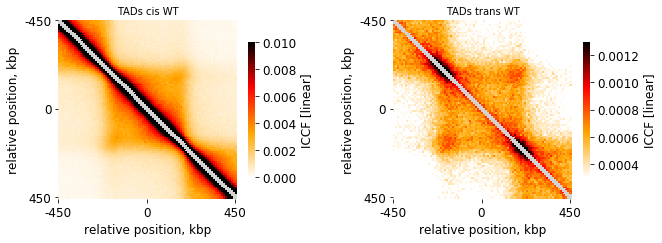

In [18]:
WINDOW_HALF_SIZE = 450000
BINSIZE = 10000

cmap = cl.LinearSegmentedColormap.from_list("fall", colors=["white", "orange" ,"red", "black"], N=256)
cmap.set_bad("lightgrey")
minMaxMap = {'cis': (0, 0.01), 'trans': (0.0003, 0.0013)}


f, ax = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)
for index, rtype in enumerate(["cis", "trans"]):
    temp = pileupICCFWT[rtype].copy()
    for i in range(-1, 2):
        temp[kth_diag_indices(temp, i)] = np.nan
    sbn.heatmap(temp, ax=ax[index],
                square=True, 
                rasterized=True,
                cmap=cmap,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={"shrink": .5, "label": "ICCF [linear]"},
                vmin=minMaxMap[rtype][0],
                vmax=minMaxMap[rtype][1])
    ax[index].set_title(f"TADs {rtype} WT",
                        fontdict={"fontsize": 10})
    ticks_pixels = np.linspace(0, WINDOW_HALF_SIZE*2//BINSIZE, 3)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*BINSIZE//1000).astype(int)
setAxis(ax, ticks_pixels, ticks_kbp)
f.set_size_inches(10, 5)
plt.show()

## Write to file

In [19]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Sororin/"
f.savefig(os.path.join(resultsdir, "2d_TAD_average_ICCF_WT.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "2d_TAD_average_ICCF_WT.pdf"), bbox_inches="tight")

## Plot 2d pileup Sorroin with the same settings

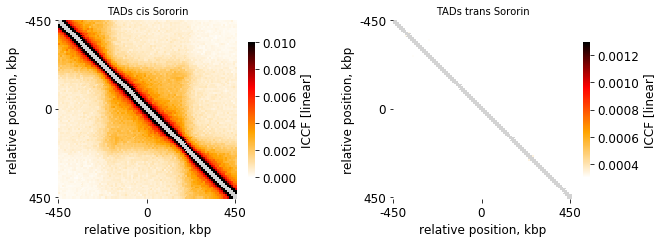

In [20]:
f, ax = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)
for index, rtype in enumerate(["cis", "trans"]):
    temp = pileupICCFSororin[rtype].copy()
    for i in range(-1, 2):
        temp[kth_diag_indices(temp, i)] = np.nan
    sbn.heatmap(temp, ax=ax[index],
                square=True, 
                rasterized=True,
                cmap=cmap,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={"shrink": .5, "label": "ICCF [linear]"},
                vmin=minMaxMap[rtype][0],
                vmax=minMaxMap[rtype][1])
    ax[index].set_title(f"TADs {rtype} Sororin",
                        fontdict={"fontsize": 10})
    ticks_pixels = np.linspace(0, WINDOW_HALF_SIZE*2//BINSIZE, 3)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*BINSIZE//1000).astype(int)
setAxis(ax, ticks_pixels, ticks_kbp)
f.set_size_inches(10, 5)
plt.show()

## Write to file

In [ ]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Sororin/"
f.savefig(os.path.join(resultsdir, "2d_TAD_average_ICCF_Sororin.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "2d_TAD_average_ICCF_Sororin.pdf"), bbox_inches="tight")

# Make line profiles for each individual TAD-boundary (Obs/exp)

In [26]:
windowsBoundaries = HT.assignRegions(450000, 10000, tadFinal["chrom"], tadFinal["mid"], arms).dropna()

In [27]:
pileupIndwWT = {interType: HT.doPileupObsExp(clrsWT[interType], expWT[interType], windowsBoundaries, collapse=False)
                 for interType in ["cis", "trans"]}

In [28]:
pileupIndwSororin = {interType: HT.doPileupObsExp(clrsSororin[interType], expSororin[interType], windowsBoundaries, collapse=False)
                 for interType in ["cis", "trans"]}

## Prepare profiles for plotting

In [34]:
obsExp1dWT = {}
for rType in ["cis", "trans"]:
    tempPile = pileupIndwWT[rType]
    tempList = []
    for boundaryIndex in range(tempPile.shape[2]):
        if boundaryIndex % 5000 == 0:
            print(boundaryIndex)
        indPile = tempPile[:, :, boundaryIndex]
        xVals, yVals = slidingDiamond(indPile, sideLen=10)
        tempFrame = pd.DataFrame({"xVals": xVals, "yVals": yVals, "ID": boundaryIndex})
        tempList.append(tempFrame)
    obsExp1dWT[rType] = pd.concat(tempList)

0
0


In [35]:
obsExp1dSororin = {}
for rType in ["cis", "trans"]:
    tempPile = pileupIndwSororin[rType]
    tempList = []
    for boundaryIndex in range(tempPile.shape[2]):
        if boundaryIndex % 5000 == 0:
            print(boundaryIndex)
        indPile = tempPile[:, :, boundaryIndex]
        xVals, yVals = slidingDiamond(indPile, sideLen=10)
        tempFrame = pd.DataFrame({"xVals": xVals, "yVals": yVals, "ID": boundaryIndex})
        tempList.append(tempFrame)
    obsExp1dSororin[rType] = pd.concat(tempList)

0
0


## Prepare profiles for plotting

In [36]:
wtPrepared = {}
for rType in ["trans", "cis"]:
    temp = obsExp1dWT[rType]
    # expand into heatmap
    tempExp = pd.pivot_table(temp, columns="xVals", index="ID", values="yVals", dropna=False)
    if rType == "trans":
        # midPoint definitio
        midPoint = int(np.median(range(len(tempExp.columns))))
        # find center enrichment
        tempExp.loc[:, "CenterVal"] = tempExp.apply(lambda x: np.nanmean(x.iloc[midPoint-5:midPoint+5]), axis=1)
        tempExp = tempExp.sort_values(by="CenterVal", ascending=False).drop("CenterVal", axis="columns")
        transOrder = tempExp.index
    else:
        tempExp = tempExp.loc[transOrder, :]
    wtPrepared[rType] = tempExp

In [37]:
sororinPrepared = {}
for rType in ["trans", "cis"]:
    temp = obsExp1dSororin[rType]
    # expand into heatmap
    tempExp = pd.pivot_table(temp, columns="xVals", index="ID", values="yVals", dropna=False)
    tempExp = tempExp.loc[transOrder, :]
    sororinPrepared[rType] = tempExp

- Note: Taking order from WT pileups

## Plot 2d profiles for WT

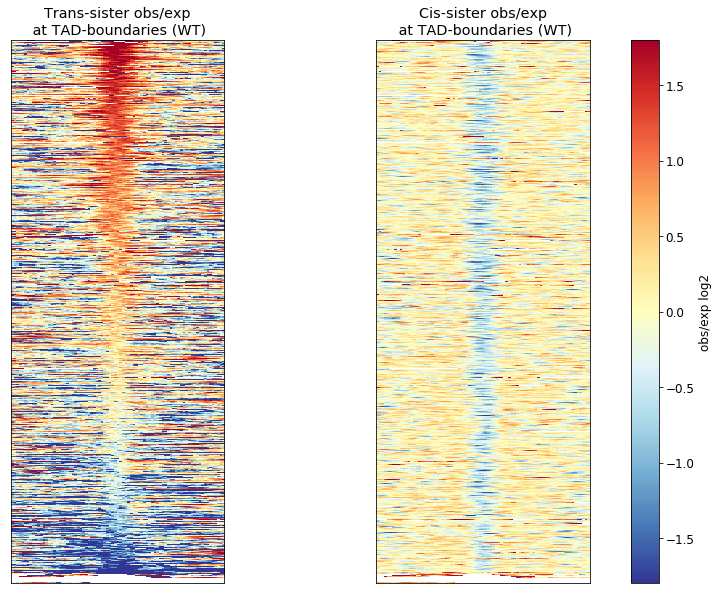

In [38]:
wtPrepared["trans"] = wtPrepared["trans"] + 0.01
wtPrepared["cis"] = wtPrepared["cis"] + 0.01

f, ax = plt.subplots(1, 2)
im = ax[0].imshow(np.log2(wtPrepared["trans"]), vmin=-1.8, vmax=1.8, aspect=0.05, cmap="RdYlBu_r", rasterized=True)
ax[1].imshow(np.log2(wtPrepared["cis"]), vmin=-1.8, vmax=1.8, aspect=0.05, cmap="RdYlBu_r", rasterized=True)
ax[0].set(title="Trans-sister obs/exp\n at TAD-boundaries (WT)")
ax[1].set(title="Cis-sister obs/exp\n at TAD-boundaries (WT)")
f.colorbar(im, ax=ax, label="obs/exp log2")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

## Write to file

In [39]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Nipbl/"
f.savefig(os.path.join(resultsdir, "2d_lineprofile_TAD_boundaries_WT.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "2d_lineprofile_TAD_boundaries_WT.pdf"), bbox_inches="tight")

## Plot 2d profiles for Sororin

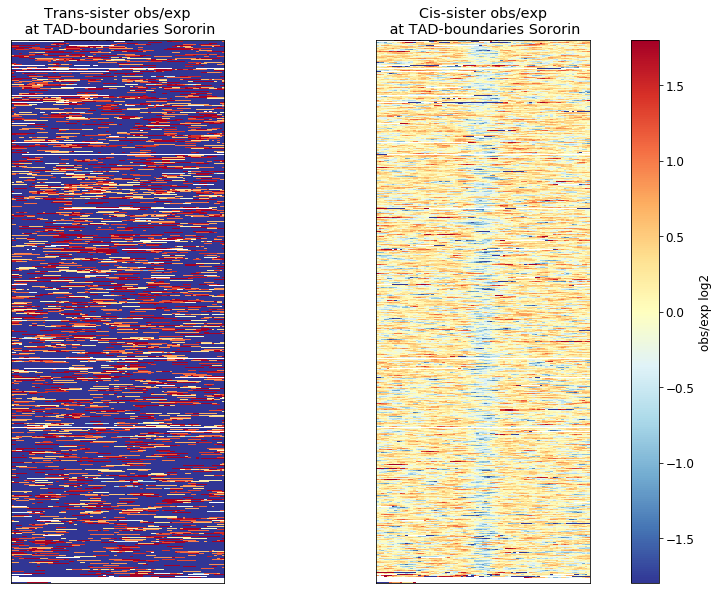

In [40]:
# add pseudocount to sororin prepared

sororinPrepared["trans"] = sororinPrepared["trans"] + 0.1
sororinPrepared["cis"] = sororinPrepared["cis"] + 0.1

f, ax = plt.subplots(1, 2)
im = ax[0].imshow(np.log2(sororinPrepared["trans"]), vmin=-1.8, vmax=1.8, aspect=0.05, cmap="RdYlBu_r", rasterized=True)
ax[1].imshow(np.log2(sororinPrepared["cis"]), vmin=-1.8, vmax=1.8, aspect=0.05, cmap="RdYlBu_r", rasterized=True)
ax[0].set(title="Trans-sister obs/exp\n at TAD-boundaries Sororin")
ax[1].set(title="Cis-sister obs/exp\n at TAD-boundaries Sororin")
f.colorbar(im, ax=ax, label="obs/exp log2")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

## Write to file

In [41]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Sororin/"
f.savefig(os.path.join(resultsdir, "2d_lineprofile_TAD_boundaries_Sororin.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "2d_lineprofile_TAD_boundaries_Sororin.pdf"), bbox_inches="tight")

# Quantify differences between Sororin and WT

In [42]:
centerWT = wtPrepared["trans"][0.0]
centerSororin = sororinPrepared["trans"][0.0]

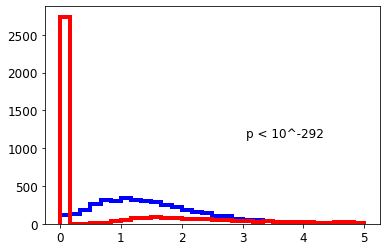

In [45]:
s, p = mannwhitneyu(centerWT, centerSororin)

orderOfMag = int(np.log10(p))

f, ax = plt.subplots()
ax.hist(centerWT, bins=30, range=(0, 5), histtype="step", color="blue", label="WT", lw=4)
ax.hist(centerSororin, bins=30, range=(0, 5), histtype="step", color="red", label="Sororin", lw=4)
ax.text(0.6, 0.4, f"p < 10^{orderOfMag}", transform=ax.transAxes)
plt.show()

In [98]:
cisXSororinICCF, cisYSororinICCF = HT.slidingDiamond(pileupsAvgSororinICCF["cis"], sideLen=20)
transXSororinICCF, transYSororinICCF = HT.slidingDiamond(pileupsAvgSororinICCF["trans"], sideLen=20)

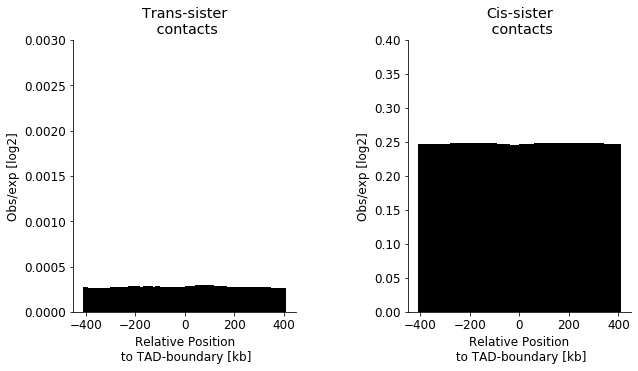

In [100]:
f, ax = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)
ax[0].bar(transXSororin * 10, transYSororinICCF,color="black", width=20)
ax[1].bar(cisXSororin * 10, cisYSororinICCF, lw=4, color="black", width=20)
sbn.despine()
ax[0].set(xlabel="Relative Position\n to TAD-boundary [kb]", ylabel="Obs/exp [log2]", title="Trans-sister\n contacts", ylim=(0, 0.003))
ax[1].set(xlabel="Relative Position\n to TAD-boundary [kb]", ylabel="Obs/exp [log2]", title="Cis-sister\n contacts", ylim=(0, 0.4))
f.set_size_inches(10, 5)
plt.show()